## Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from os import listdir
from os.path import isfile, join

## Some initial config

In [12]:
INPUT_DIMS = [32,32]
BIN_DTYPE = 'int16'
PATH = "../Images/bin/"
SAMPLE = None
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.10/(1-TEST_SIZE)

## Generate label DataFrame

In [13]:
liver_images = np.array([f for f in listdir(PATH) if isfile(join(PATH, f))])
#print(f"Number of liver image files: {len(liver_images)}")
cancer_types = np.array([f.split('_')[0] for f in liver_images])
patient_numbers = np.array([int(f.split('_')[1]) for f in liver_images])
slice_numbers = np.array([int(f.split('_')[2].split('.')[0]) for f in liver_images])

ldata = {'filename' : liver_images, 
         'cancer_type' : cancer_types, 
         'patient_id' : patient_numbers, 
         'slice_number' : slice_numbers}

image_labels = pd.DataFrame(data=ldata).sort_values(['cancer_type','patient_id','slice_number'],
                                                   ignore_index=True)
if SAMPLE:
    image_labels = image_labels.sample(SAMPLE)
image_labels.head()

,filename,cancer_type,patient_id,slice_number
0,HCC_1_1.bin,HCC,1,1
1,HCC_1_2.bin,HCC,1,2
2,HCC_1_3.bin,HCC,1,3
3,HCC_1_4.bin,HCC,1,4
4,HCC_1_5.bin,HCC,1,5


### Display some sample images

In [14]:
def get_image(fpath,d_type=BIN_DTYPE,dims=INPUT_DIMS):
    '''
    Returns a numpy array given a .bin file path and
    image dimensionality. Assumes input bin files are square
    
    Parameters
        fpath: file path to .bin file
        d_type: data type of .bin file
        dims: image dimensionality
    Returns
        image: numpy array from bin file data
    '''
    im_data = np.fromfile(fpath,d_type)
    n = int(np.sqrt(len(im_data)))
    image = np.reshape(np.fromfile(fpath,d_type),[n,n])
    scaled_image = cv2.resize(image,dims)
    return scaled_image

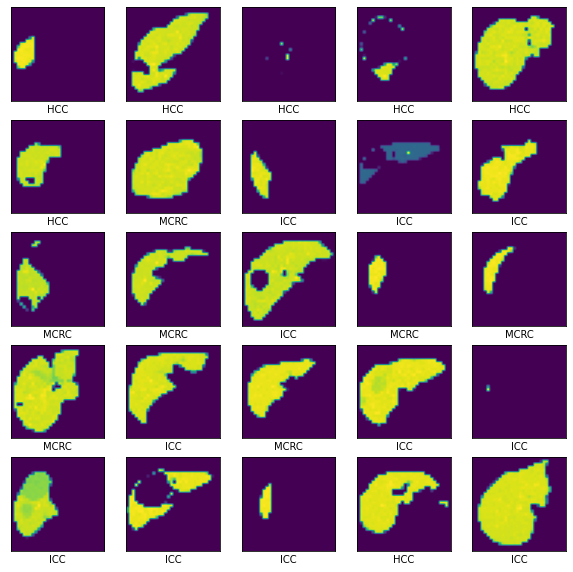

In [15]:
sample_labels = image_labels.sample(25)


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = get_image(PATH+sample_labels.filename.iloc[i])
    ctype = sample_labels.cancer_type.iloc[i]
    plt.imshow(img)
    plt.xlabel(ctype)
plt.show()

## Split Data into training and testing sets

In [16]:
#split df into cancer types
HCC_labels = image_labels.loc[image_labels.cancer_type == 'HCC']
ICC_labels = image_labels.loc[image_labels.cancer_type == 'ICC']
MCRC_labels = image_labels.loc[image_labels.cancer_type == 'MCRC']
print(f"{len(HCC_labels)} HCC images found")
print(f"{len(ICC_labels)} ICC images found")
print(f"{len(MCRC_labels)} MCRC images found")

5974 HCC images found
13140 ICC images found
9482 MCRC images found


In [17]:
from sklearn.model_selection import train_test_split

def split_patients(pat_ids,tsize=TEST_SIZE):
    train, test = train_test_split(pat_ids, test_size=tsize)
    return train, test

In [18]:
#for each cancer type, split into training, validation, and testing sets
hcc_all_train_ids, hcc_test_ids = split_patients(HCC_labels.patient_id.unique())
hcc_train_ids, hcc_valid_ids = split_patients(hcc_all_train_ids, VALIDATION_SIZE)

icc_all_train_ids, icc_test_ids = split_patients(ICC_labels.patient_id.unique())
icc_train_ids, icc_valid_ids = split_patients(icc_all_train_ids, VALIDATION_SIZE)

mcrc_all_train_ids, mcrc_test_ids = split_patients(MCRC_labels.patient_id.unique())
mcrc_train_ids, mcrc_valid_ids = split_patients(mcrc_all_train_ids, VALIDATION_SIZE)

#then generate label dataframes for each
HCC_train_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_train_ids)]
HCC_valid_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_valid_ids)]
HCC_test_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_test_ids)]

ICC_train_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_train_ids)]
ICC_valid_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_valid_ids)]
ICC_test_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_test_ids)]

MCRC_train_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_train_ids)]
MCRC_valid_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_valid_ids)]
MCRC_test_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_test_ids)]

In [19]:
train_rows=pd.concat([MCRC_train_labels,ICC_train_labels,HCC_train_labels],ignore_index=True).sample(frac=1)
valid_rows=pd.concat([MCRC_valid_labels,ICC_valid_labels,HCC_valid_labels],ignore_index=True).sample(frac=1)
test_rows=pd.concat([MCRC_test_labels,ICC_test_labels,HCC_test_labels],ignore_index=True).sample(frac=1)

total = len(train_rows) + len(valid_rows) + len(test_rows)
print(f"{total} total images split")
print(f"Train/validation/test ratio: {len(train_rows)/total:.2f}/{len(valid_rows)/total:.2f}/{len(test_rows)/total:.2f}")

28596 total images split
Train/validation/test ratio: 0.74/0.11/0.15


In [20]:
# dict to map cancer types to numerical classes
c_class = {'HCC':0,
          'ICC':1,
          'MCRC':2}

In [21]:
#preallocate training data array
n_train = len(train_rows)
train_images = np.zeros([n_train]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_train):
    print(f"{i+1}/{n_train}", end='\r')
    train_images[i,:,:]=get_image(PATH+train_rows.filename.iloc[i])

train_labels = tf.one_hot(np.array([c_class[c] for c in train_rows.cancer_type.tolist()]),3)

In [22]:
#preallocate validation data array
n_valid = len(valid_rows)
valid_images = np.zeros([n_valid]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_valid):
    print(f"{i+1}/{n_valid}", end='\r')
    valid_images[i,:,:]=get_image(PATH+valid_rows.filename.iloc[i])

valid_labels = tf.one_hot(np.array([c_class[c] for c in valid_rows.cancer_type.tolist()]),3)

In [23]:
#preallocate testing data array
n_test = len(test_rows)
test_images = np.zeros([n_test]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_test):
    print(f"{i+1}/{n_test}", end='\r')
    test_images[i,:,:]=get_image(PATH+test_rows.filename.iloc[i])

test_labels = tf.one_hot(np.array([c_class[c] for c in test_rows.cancer_type.tolist()]),3)

In [24]:
#normalize images
train_images = (train_images + 1000)/4096
valid_images = (valid_images + 1000)/4096
test_images = (test_images + 1000)/4096

## Create Convolutional Base

In [27]:
#construct and compile the model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(0)
from tensorflow.random import set_seed
set_seed(0)

K.clear_session()
inputShape = (train_images.shape[1],train_images.shape[2],1)

inp = Input(shape=inputShape)
conv1 = Conv2D(8,3, activation='relu')(inp)
pool1 = MaxPooling2D((2,2))(conv1)
conv2 = Conv2D(8,3, activation='relu')(pool1)
pool2 = MaxPooling2D((2,2))(conv2)
flat1 = Flatten()(conv2)
dense1 = Dense(256, activation='relu')(flat1)
dense2 = Dense(64, activation='relu')(dense1)
out = Dense(3, activation='softmax')(dense2)

model = Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         584       
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 dense (Dense)               (None, 256)               346368    
                                                             

In [28]:
optimizer = Adam(learning_rate=0.002)

callback = EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics='accuracy')

history = model.fit(train_images,
                     train_labels,
                          epochs=20, batch_size=32, verbose=1,
                    validation_data=(valid_images,valid_labels),callbacks=[callback])

Epoch 1/20
665/665 [==============================] - 6s 8ms/step - loss: 0.9224 - accuracy: 0.5512 - val_loss: 0.9912 - val_accuracy: 0.5236
Epoch 2/20
665/665 [==============================] - 5s 8ms/step - loss: 0.6517 - accuracy: 0.7171 - val_loss: 1.2741 - val_accuracy: 0.4738
Epoch 3/20
665/665 [==============================] - 5s 8ms/step - loss: 0.4536 - accuracy: 0.8084 - val_loss: 1.4135 - val_accuracy: 0.5121
Epoch 4/20
665/665 [==============================] - 5s 8ms/step - loss: 0.3239 - accuracy: 0.8638 - val_loss: 1.6823 - val_accuracy: 0.5021


132/132 - 0s - loss: 2.0169 - accuracy: 0.4440 - 404ms/epoch - 3ms/step
0.44396960735321045


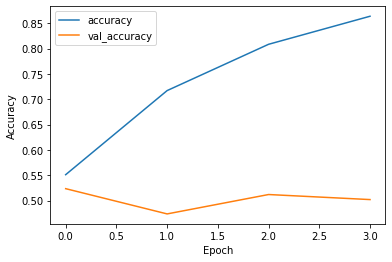

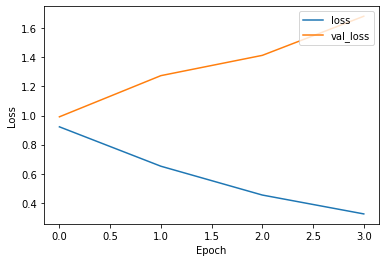

In [29]:
plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.35, 1])
plt.legend(loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 2])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

## Results

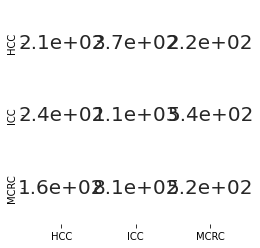

In [52]:
from sklearn import metrics
import seaborn as sns
from matplotlib.colors import ListedColormap

y_actual = test_labels.numpy().argmax(axis=1).astype(int)
y_preds = model.predict(test_images).argmax(axis=1)

confusion_matrix = metrics.confusion_matrix(y_actual, y_preds)
#con_mat_norm = (con_mat.T / con_mat.sum(axis=1)).T

conf_figure = pd.DataFrame(confusion_matrix, index = ['HCC', 'ICC', 'MCRC'], columns = ['HCC', 'ICC', 'MCRC'])


plt.figure(figsize=(4,4))

sns.heatmap(conf_figure,
                cbar=False,
                square=False,
                annot=True,
                annot_kws={"size": 20},
                cmap=ListedColormap(['white']),
                linewidths=0.5)
plt.show()